## User Interface

This notebook walks you through five steps to clean your dataset. Previews of the changes should be made on a "dev dataset" which can be a manual copy-paste of some images in a file structure similar to that of the actual dataset. Statistics are collected on these to help guide the desired parameters for later cleaning steps. Once you've set them based on the dev dataset, they will be used to process the full dataset in the background. Because of this, **please make sure your dev dataset is a good representative sample of the actual DATA**. These steps are listed below:
1. Dataset setup: set the datasets' paths, the folder depth at which to aggregate the images into a common tensor for use at training/inference time, and the filenames for each channel and what their respective positions should be in the processed data.
2. Cell segmentation: no parameters here at the moment, feel free to run on the full dataset once you've seen the preview on the dev dataset. The one step in here you might need to review is how the masks get merged if there are cells missing nuclei and vice versa.
3. Mask post-processing: removing cells that were cut off by the image edge, merging cells that were incorrectly split based on dialating their nuclei, and deleting small cells/nuclei.
4. Crop: based on the size distribution of the cell bounding boxes.
5. Normalization: based on a variety of possible choices

In [1]:
import os
from pathlib import Path
from glob import glob
from pprint import pprint

import numpy as np
import torch

from scipy import ndimage
import cv2
from skimage import measure, segmentation, morphology
import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei

from microfilm.microplot import microshow
import seaborn as sns

In [2]:
gpu_num = 0
device = f"cuda:{gpu_num}" if torch.cuda.is_available() else "cpu"
print(f"Running on device: {device}")

Running on device: cuda:0


# Dataset Setup

In [3]:
DATA_DIR = Path("/data/ishang/CCNB1-dataset/") # NEEDS TO BE ABSOLUTE PATH
DEV_DATA_DIR = Path("/home/ishang/HPA-embedding/dev-dataset") # NEEDS TO BE ABSOLUTE PATH
# TODO this should work even if they are not pngs...
CHANNEL_NAMES = ["cyclinb1", "microtubule", "nuclei"] # these are the names of the channels in the order they appear in the image, the names should be the same as the file name (without the .png extension)
# the below are channels whose indices we need to know explicitly
DAPI = 2
TUBL = 1
ANLN = None

In [4]:
DATA_STR, DATA_FOLDER_PATH  = str(DATA_DIR), "data-folder.txt"
DEV_DATA_STR, DEV_DATA_FOLDER_PATH  = str(DEV_DATA_DIR), "dev-data-folder.txt"

In [5]:
# first number in the output is the total number of images found and the second is the list of folders underwhich all images will be aggregated in the dev dataset
# in this case we automatically aggregate everything at the first level of depth in the dataset, if you want to group by well, experiment, etc. please add the lists of absolute paths to the "*data-folder.txt" files accordingly
!find $DATA_STR -type d > $DATA_FOLDER_PATH
!sed -i '1d' $DATA_FOLDER_PATH
!cat $DATA_FOLDER_PATH | wc -l
!find $DEV_DATA_STR -type d > $DEV_DATA_FOLDER_PATH
!sed -i '1d' $DEV_DATA_FOLDER_PATH
!cat $DEV_DATA_FOLDER_PATH

1714
/home/ishang/HPA-embedding/dev-dataset/C_1--Stage01
/home/ishang/HPA-embedding/dev-dataset/11_TileScan 6--Stage00
/home/ishang/HPA-embedding/dev-dataset/B_1--Stage01
/home/ishang/HPA-embedding/dev-dataset/D_4--Stage20
/home/ishang/HPA-embedding/dev-dataset/10_R1--Stage01
/home/ishang/HPA-embedding/dev-dataset/TileScan 7_A5 Region1--Stage01
/home/ishang/HPA-embedding/dev-dataset/field--X01--Y00_image--L0000--S00--U08--V04--J17--E02--O02--X01--Y00--T0000--Z00--C0


In [5]:
# below is an example of the level of the file hierarchy at which the data will be aggregated for the dev-dataset
def image_paths_from_folders(folders_file):
    image_paths = list(open(folders_file, "r"))
    image_paths = [Path(x.strip()) for x in image_paths]
    return image_paths
image_paths = image_paths_from_folders(DATA_FOLDER_PATH)
dev_image_paths = image_paths_from_folders(DEV_DATA_FOLDER_PATH)
pprint(dev_image_paths)

[PosixPath('/home/ishang/HPA-embedding/dev-dataset/C_1--Stage01'),
 PosixPath('/home/ishang/HPA-embedding/dev-dataset/11_TileScan 6--Stage00'),
 PosixPath('/home/ishang/HPA-embedding/dev-dataset/B_1--Stage01'),
 PosixPath('/home/ishang/HPA-embedding/dev-dataset/D_4--Stage20'),
 PosixPath('/home/ishang/HPA-embedding/dev-dataset/10_R1--Stage01'),
 PosixPath('/home/ishang/HPA-embedding/dev-dataset/TileScan 7_A5 Region1--Stage01'),
 PosixPath('/home/ishang/HPA-embedding/dev-dataset/field--X01--Y00_image--L0000--S00--U08--V04--J17--E02--O02--X01--Y00--T0000--Z00--C0')]


# Segmentation

### DO NOT RERUN THIS CELL BELOW!!! YOU WILL HAVE TO KILL THE PROCESS AND RESTART THE KERNEL

In [6]:
# Note that the source change warning below is expected
pwd = Path(os.getcwd())
NUC_MODEL = pwd / "HPA-Cell-Segmentation" / "nuclei-model.pth"
CELL_MODEL = pwd / "HPA-Cell-Segmentation" / "cell-model.pth"

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
segmentator = cellsegmentator.CellSegmentator(
    str(NUC_MODEL), str(CELL_MODEL), device=device, padding=True, multi_channel_model=(ANLN is not None)
)

please compile abn


/home/ishang/miniconda3/envs/data-prep/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'pytorch_zoo.unet.DPNUnet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ishang/miniconda3/envs/data-prep/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ishang/miniconda3/envs/data-prep/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can

### DO NOT RERUN THIS ^^^^^ YOU WILL HAVE TO KILL THE PROCESS AND RESTART THE KERNEL

In [7]:
def merge_extraneous_elements(targets, elements):
    extraneous_elements = np.unique(elements[~np.isin(elements, targets)])
    extraneous_elements = extraneous_elements[extraneous_elements != 0] # remove background
    target_masks = np.stack([targets == target for target in np.unique(targets)])
    target_coms = np.array([ndimage.center_of_mass(mask) for mask in target_masks])
    for element in extraneous_elements:
        element_com = ndimage.center_of_mass(elements == element)
        target_distances = np.linalg.norm(target_coms - element_com, axis=1)
        closest_target = np.unique(targets)[np.argmin(target_distances)]
        elements[elements == element] = closest_target
    return elements

def get_masks(segmentator, image_paths, merge_missing=True):
    """
    Get the masks for the images in image_paths using HPA-Cell-Segmentation
    It places all the cells in the target directory from image_paths into a single
    """
    images_paths = []
    nuclei_mask_paths = []
    cell_mask_paths = []
    for image_path in image_paths:
        if (image_path / "images.npy").exists():
            images_paths.append(image_path / "images.npy")
        if ((image_path / "cell_masks.npy").exists() and
            (image_path / "nuclei_masks.npy").exists()):
            nuclei_mask_paths.append(image_path / "nuclei_masks.npy")
            cell_mask_paths.append(image_path / "cell_masks.npy")
            continue
        glob_channel_images = lambda image_path, c: list(glob(f"{str(image_path)}/**/*{CHANNEL_NAMES[c]}.png", recursive=True))
        dapi_paths = sorted(glob_channel_images(image_path, DAPI))
        tubl_paths = sorted(glob_channel_images(image_path, TUBL))
        anln_paths = sorted(glob_channel_images(image_path, ANLN)) if ANLN is not None else None
        
        for dapi, tubl in zip(dapi_paths, tubl_paths):
            assert str(dapi).split(CHANNEL_NAMES[DAPI])[0] == str(tubl).split(CHANNEL_NAMES[TUBL])[0], f"File mismatch for {dapi} and {tubl}"
        if ANLN is not None and anln_paths is not None:
            for dapi, anln in zip(dapi_paths, anln_paths):
                assert str(dapi).split(CHANNEL_NAMES[DAPI])[0] == str(anln).split(CHANNEL_NAMES[ANLN])[0], f"File mismatch for {dapi} and {anln}"

        load_image = lambda path_list: [cv2.imread(str(x), cv2.IMREAD_UNCHANGED) for x in path_list]
        dapi_images = load_image(dapi_paths)
        tubl_images = load_image(tubl_paths)
        anln_images = load_image(anln_paths) if anln_paths is not None else None

        ref_images = [tubl_images, anln_images, dapi_images]
        nuc_segmentation = segmentator.pred_nuclei(ref_images[2])
        cell_segmentation = segmentator.pred_cells(ref_images)

        # post-processing
        nuclei_masks, cell_masks = [], []
        for i in range(len(ref_images[2])): # 2 because DAPI will always be present and we set the order manually
            nuclei_mask = label_nuclei(nuc_segmentation[i])
            nuclei_mask, cell_mask = label_cell(
                nuc_segmentation[0], cell_segmentation[i]
            )
            nuclei_masks.append(nuclei_mask)
            cell_masks.append(cell_mask)
        nuclei_masks = np.stack(nuclei_masks, axis=0)
        cell_masks = np.stack(cell_masks, axis=0)

        # apply preprocessing mask if the user want to merge nuclei
        images = []
        for c, channel in enumerate(CHANNEL_NAMES):
            channel_paths = sorted(glob_channel_images(image_path, c))
            channel_images = load_image(channel_paths)
            channel_images = np.stack(channel_images, axis=0)
            images.append(channel_images)
        images = np.stack(images, axis=1)

        for i in [0, -2, -1]:
            assert images.shape[i] == nuclei_masks.shape[i] == cell_masks.shape[i], f"Shape mismatch for images and masks in {image_path}, at index {i}, images has shape {images.shape}, nuclei_masks has shape {nuclei_masks.shape}, cell_masks has shape {cell_masks.shape}"

        image_idx = 0
        for image, nuclei_mask, cell_mask in zip(images, nuclei_masks, cell_masks):
            if set(np.unique(nuclei_mask)) != set(np.unique(cell_mask)): 
                print(f"Mask mismatch for {image_path}, nuclei: {np.unique(nuclei_masks)}, cell: {np.unique(cell_masks)}")
                microshow(image[(DAPI, TUBL),], cmaps=["pure_blue", "pure_red"], label_text=f"Image: {Path(image_path).name}[{image_idx}] ")

                # show cells without nuclei if any
                missing_nuclei = np.asarray(list(set(np.unique(cell_mask)) - set(np.unique(nuclei_mask))))
                if len(missing_nuclei) > 0:
                    microshow(image[TUBL] * np.isin(cell_mask, missing_nuclei), cmaps=["pure_red"], label_text=f"Cells missing nuclei: {missing_nuclei}")

                # show nuclei without cells if any
                missing_cells = np.asarray(list(set(np.unique(nuclei_mask)) - set(np.unique(cell_mask))))
                if len(missing_cells) > 0:
                    microshow(image[DAPI] * np.isin(nuclei_mask, missing_cells), cmaps=["pure_blue"], label_text=f"Nuclei without cells: {missing_cells}")

                # show cell masks and merge missing cells based on nuclei
                microshow(cell_mask, label_text=f"Cell mask: {np.unique(cell_mask)}")
                if len(missing_nuclei) > 0 and merge_missing:
                    cell_mask = merge_extraneous_elements(nuclei_mask, cell_mask)
                    microshow(cell_mask, label_text=f"Cell mask after merging: {np.unique(cell_mask)}")

                # show nuclei masks and merge missing nuclei based on cells
                microshow(nuclei_mask, label_text=f"Nuclei mask: {np.unique(nuclei_mask)}")
                if len(missing_cells) > 0 and merge_missing:
                    nuclei_mask = merge_extraneous_elements(cell_mask, nuclei_mask)
                    microshow(nuclei_mask, label_text=f"Nuclei mask after merging: {np.unique(nuclei_mask)}")

        assert np.max(nuclei_masks) > 0 and np.max(cell_masks) > 0, f"No nuclei or cell mask found for {image_path}"
        assert set(np.unique(nuclei_masks)) == set(np.unique(cell_masks)), f"Mask mismatch for {image_path}, nuclei: {np.unique(nuclei_masks)}, cell: {np.unique(cell_masks)}"

        np.save(image_path / "images.npy", images)
        np.save(image_path / "nuclei_masks.npy", nuclei_masks)
        np.save(image_path / "cell_masks.npy", cell_masks)

        images_paths.append(image_path / "images.npy")
        nuclei_mask_paths.append(image_path / "nuclei_masks.npy")
        cell_mask_paths.append(image_path / "cell_masks.npy")

    return image_paths, nuclei_mask_paths, cell_mask_paths

In [8]:
def clean_segmentations(image_paths): 
    for image_path in image_paths:
            if (image_path / "images.npy").exists():
                os.remove(image_path / "images.npy") 
            if (image_path / "cell_masks.npy").exists():
                os.remove(image_path / "cell_masks.npy")
            if (image_path / "nuclei_masks.npy").exists():
                os.remove(image_path / "nuclei_masks.npy")

clean_segmentations(dev_image_paths)

In [9]:
# View the dev-dataset directory before generating the masks and after
!tree $DEV_DATA_DIR

/home/ishang/HPA-embedding/dev-dataset
├── 10_R1--Stage01
│   ├── cell_mask.npy
│   ├── cyclinb1.png
│   ├── microtubule.png
│   ├── nuclei_mask.npy
│   └── nuclei.png
├── 11_TileScan 6--Stage00
│   ├── cell_mask.npy
│   ├── cyclinb1.png
│   ├── microtubule.png
│   ├── nuclei_mask.npy
│   └── nuclei.png
├── B_1--Stage01
│   ├── cell_border_mask_output.png
│   ├── cell_border_mask_skeleton.png
│   ├── cell_combined_labels_color.png
│   ├── cell_combined_labels.png
│   ├── cyclinb1.png
│   ├── microtubule.png
│   ├── nuclei_border_mask_label.png
│   ├── nuclei_border_mask_output_color.png
│   ├── nuclei_border_mask_output.png
│   └── nuclei.png
├── C_1--Stage01
│   ├── cyclinb1.png
│   ├── microtubule.png
│   └── nuclei.png
├── D_4--Stage20
│   ├── cyclinb1.png
│   ├── microtubule.png
│   └── nuclei.png
├── field--X01--Y00_image--L0000--S00--U08--V04--J17--E02--O02--X01--Y00--T0000--Z00--C0
│   ├── cell_mask.npy
│   ├── cyclinb1.png
│   ├── microtubule.png
│   ├── nuclei_mask.npy
│   └──

/home/ishang/miniconda3/envs/data-prep/lib/python3.8/site-packages/hpacellseg/cellsegmentator.py:204: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  image = transform.rescale(image, self.scale_factor, multichannel=True)
/home/ishang/miniconda3/envs/data-prep/lib/python3.8/site-packages/hpacellseg/cellsegmentator.py:292: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  cell_image = transform.rescale(image, self.scale_factor, multichannel=True)


Mask mismatch for /home/ishang/HPA-embedding/dev-dataset/C_1--Stage01, nuclei: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15], cell: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[PosixPath('/home/ishang/HPA-embedding/dev-dataset/C_1--Stage01/nuclei_masks.npy'), PosixPath('/home/ishang/HPA-embedding/dev-dataset/11_TileScan 6--Stage00/nuclei_masks.npy'), PosixPath('/home/ishang/HPA-embedding/dev-dataset/B_1--Stage01/nuclei_masks.npy'), PosixPath('/home/ishang/HPA-embedding/dev-dataset/D_4--Stage20/nuclei_masks.npy'), PosixPath('/home/ishang/HPA-embedding/dev-dataset/10_R1--Stage01/nuclei_masks.npy'), PosixPath('/home/ishang/HPA-embedding/dev-dataset/TileScan 7_A5 Region1--Stage01/nuclei_masks.npy'), PosixPath('/home/ishang/HPA-embedding/dev-dataset/field--X01--Y00_image--L0000--S00--U08--V04--J17--E02--O02--X01--Y00--T0000--Z00--C0/nuclei_masks.npy')] [PosixPath('/home/ishang/HPA-embedding/dev-dataset/C_1--Stage01/cell_masks.npy'), PosixPath('/home/ishang/HPA-embedding/dev-datase

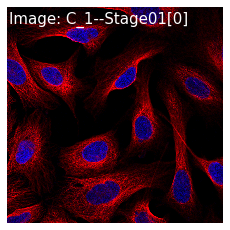

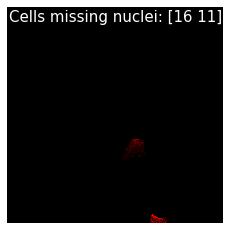

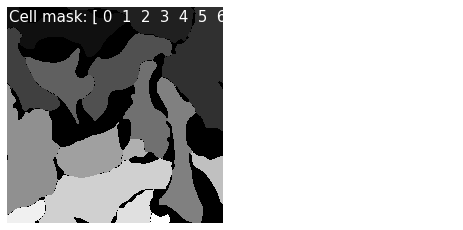

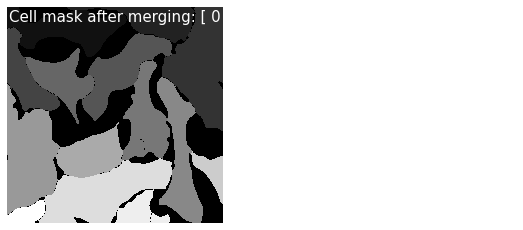

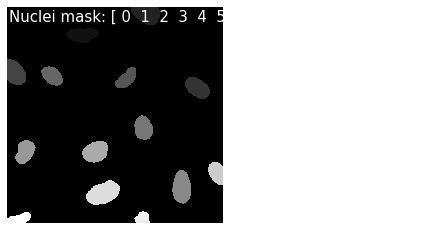

In [10]:
image_paths, nuclei_mask_paths, cell_mask_paths = get_masks(segmentator, dev_image_paths)
print(nuclei_mask_paths, cell_mask_paths)
!tree $DEV_DATA_DIR

View the masks for some sample images below


/home/ishang/miniconda3/envs/data-prep/lib/python3.8/site-packages/microfilm/microplot.py:164: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  microim.fig = plt.figure(frameon=False, dpi=microim.dpi)


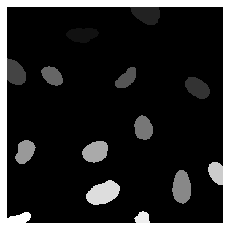

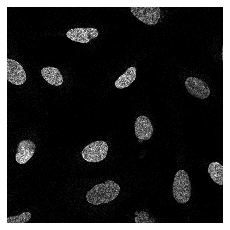

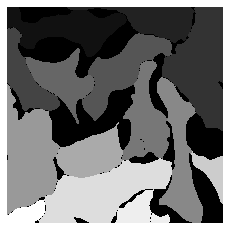

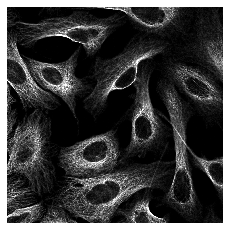

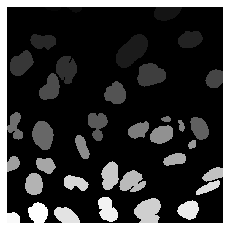

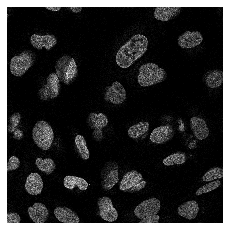

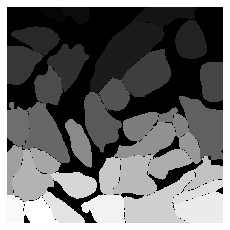

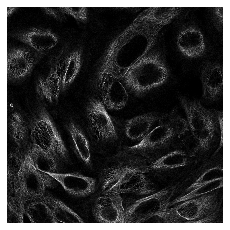

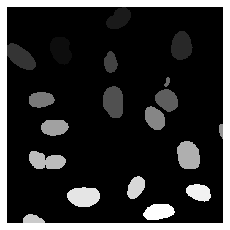

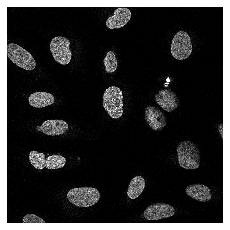

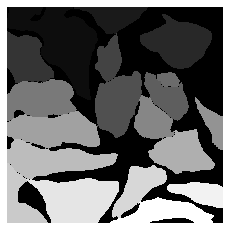

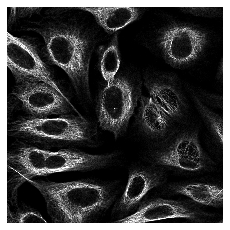

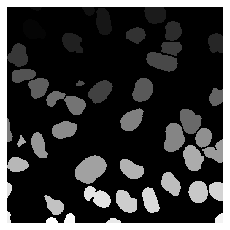

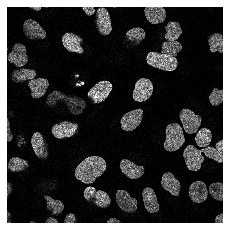

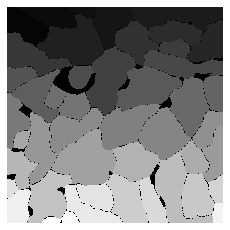

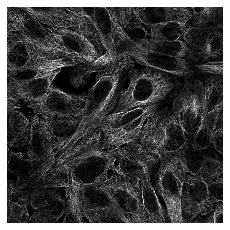

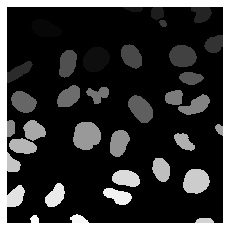

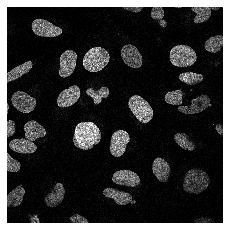

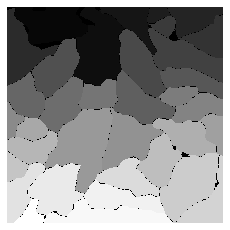

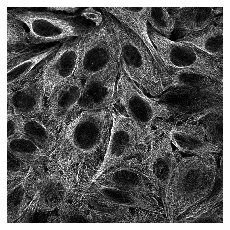

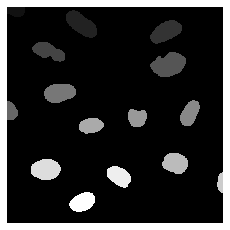

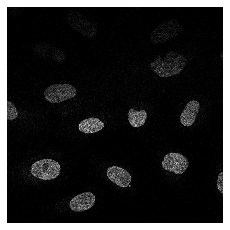

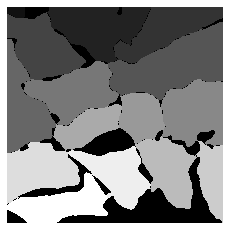

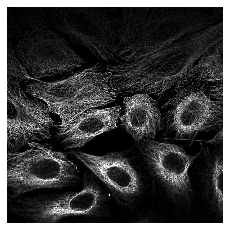

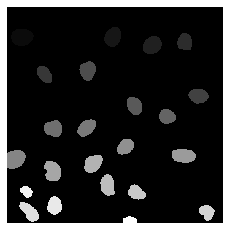

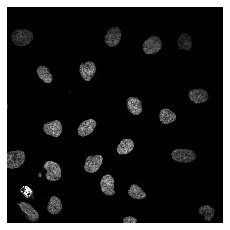

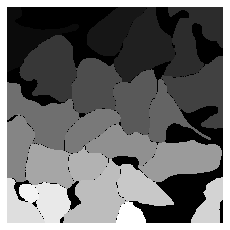

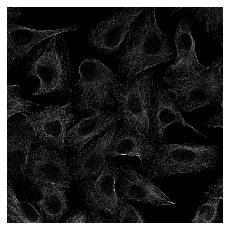

In [11]:
print("View the masks for some sample images below")
for nuclei_path, cell_path, image_path in zip(nuclei_mask_paths, cell_mask_paths, dev_image_paths):
    sample_nuclei_mask = np.load(nuclei_path)
    sample_nuclei = cv2.imread(str(image_path / (CHANNEL_NAMES[DAPI] + ".png")), cv2.IMREAD_UNCHANGED)
    microshow(sample_nuclei_mask)
    microshow(sample_nuclei)

    sample_cell_mask = np.load(cell_path)
    sample_microtuble = cv2.imread(str(image_path / (CHANNEL_NAMES[TUBL] + ".png")), cv2.IMREAD_UNCHANGED)
    microshow(sample_cell_mask)
    microshow(sample_microtuble)

In [12]:
def clear_border(cell_mask, nuclei_mask):
    # inside clear_border they make borders by dimension. So if you have a 2D image, 
    # they make a 2D border, if you have a 3D image, they make a 3D border, which means the
    # first and last channels are fully borders. So we need to squeeze the image to 2D beforehand
    cell_mask, nuclei_mask = np.squeeze(cell_mask), np.squeeze(nuclei_mask)
    assert set(np.unique(nuclei_mask)) == set(np.unique(cell_mask)), f"Mask mismatch before clearing border, nuclei: {np.unique(nuclei_mask)}, cell: {np.unique(cell_mask)}"

    num_removed = 0
    cleared_nuclei_mask = segmentation.clear_border(nuclei_mask)
    keep_value = np.unique(cleared_nuclei_mask)
    bordering_cells = np.isin(cell_mask, keep_value)
    cleared_cell_mask = cell_mask * bordering_cells
    num_removed = len(np.unique(nuclei_mask)) - len(keep_value)
    if num_removed == np.max(nuclei_mask):
        assert np.max(keep_value) == 0, f"Something went wrong with clearing the border, num_removed is the same as the highest index mask in nuclei mask, but the keep_value {np.max(keep_value)} != 0"
    nuclei_mask = cleared_nuclei_mask
    cell_mask = cleared_cell_mask

    assert set(np.unique(nuclei_mask)) == set(np.unique(cell_mask)), f"Mask mismatch after clearing border, nuclei: {np.unique(nuclei_mask)}, cell: {np.unique(cell_mask)}"
    return cell_mask, nuclei_mask, num_removed

def remove_small_objects(cell_mask, nuclei_mask, min_size=1000):
    num_removed = 0

    cell_mask = morphology.remove_small_objects(cell_mask, min_size=min_size)
    num_removed = len(np.unique(nuclei_mask)) - len(np.unique(cell_mask))
    nuclei_mask = nuclei_mask * (cell_mask > 0)
    assert set(np.unique(nuclei_mask)) == set(np.unique(cell_mask)), f"Mask mismatch after removing small objects, nuclei: {np.unique(nuclei_mask)}, cell: {np.unique(cell_mask)}"

    nuclei_mask = morphology.remove_small_objects(nuclei_mask, min_size=min_size)
    num_removed += len(np.unique(cell_mask)) - len(np.unique(nuclei_mask))
    cell_mask = cell_mask * np.isin(cell_mask, np.unique(nuclei_mask))
    assert set(np.unique(nuclei_mask)) == set(np.unique(cell_mask)), f"Mask mismatch after removing small objects, nuclei: {np.unique(nuclei_mask)}, cell: {np.unique(cell_mask)}"

    return cell_mask, nuclei_mask, num_removed

def merge_nuclei(nuclei_mask, cell_mask, dialation_radius=20):
    bin_nuc_mask = (nuclei_mask > 0).astype(np.int8)
    cls_nuc = morphology.closing(bin_nuc_mask, morphology.disk(dialation_radius))
    # get the labels of touching nuclei
    new_label_map = morphology.label(cls_nuc)
    new_label_idx = np.unique(new_label_map)[1:]

    new_cell_mask = np.zeros_like(cell_mask)
    new_nuc_mask = np.zeros_like(nuclei_mask)
    for new_label in new_label_idx:
        # get the label of the touching nuclei
        old_labels = np.unique(nuclei_mask[new_label_map == new_label])
        old_labels = old_labels[old_labels != 0]

        new_nuc_mask[np.isin(nuclei_mask, old_labels)] = new_label
        new_cell_mask[np.isin(cell_mask, old_labels)] = new_label

        # for old_label in old_labels:
        #     new_cell_mask[cell_mask == old_label] = new_label
        #     new_nuc_mask[nuclei_mask == old_label] = new_label
    return new_nuc_mask, new_cell_mask


def clean_cell_masks(
    cell_mask,
    nuclei_mask,
    remove_size=1000, # remove cells smaller than remove_size, based on the area of the bounding box, honestly could be higher, mb 2500. Make 0 to turn off.
    dialation_radius=20, # this is for 2048x2048 images adjust as needed. Make 0 to turn off.
):
    num_removed = 0
    ### see if nuclei are touching and merge them
    if dialation_radius > 0:
        nuclei_mask, cell_mask = merge_nuclei(nuclei_mask, cell_mask, dialation_radius=dialation_radius)
        assert set(np.unique(nuclei_mask)) == set(np.unique(cell_mask))
    else:
        cell_mask = cell_mask
        nuclei_mask = nuclei_mask

    region_props = measure.regionprops(cell_mask, (cell_mask > 0).astype(np.uint8))
    pre_size = len(region_props)
    if remove_size > 0:
        region_props = [x for x in region_props if x.area > remove_size]
        num_removed += pre_size - len(region_props)
    bbox_array = np.array([x.bbox for x in region_props])

    # convert x1,y1,x2,y2 to x,y,w,h
    bbox_array[:, 2] = bbox_array[:, 2] - bbox_array[:, 0]
    bbox_array[:, 3] = bbox_array[:, 3] - bbox_array[:, 1]

    # com_array = np.array([x.weighted_centroid for x in region_props])

    return cell_mask, nuclei_mask, bbox_array, num_removed

Fraction removed from border clearing: 0.25


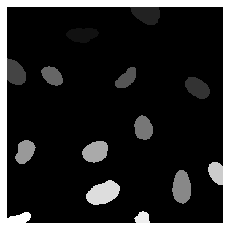

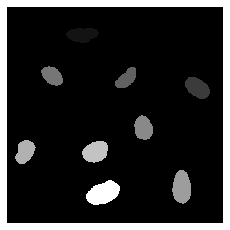

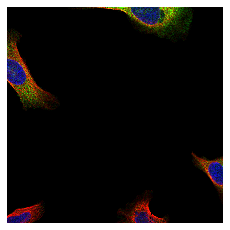

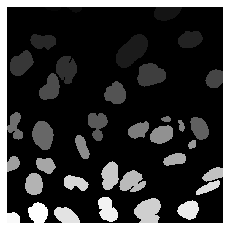

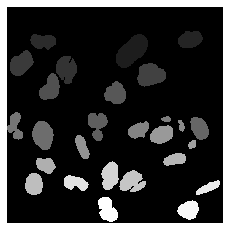

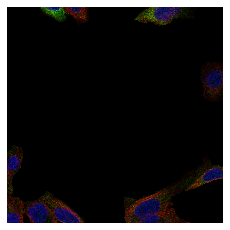

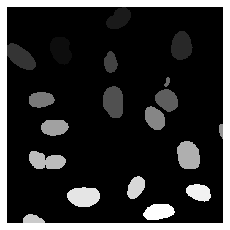

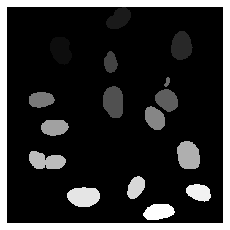

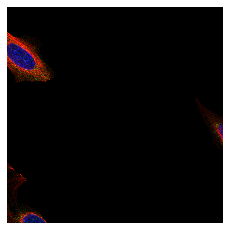

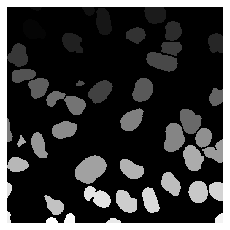

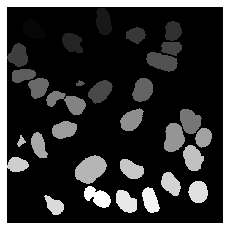

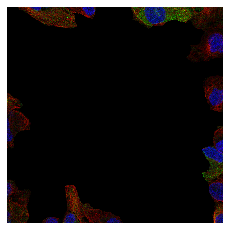

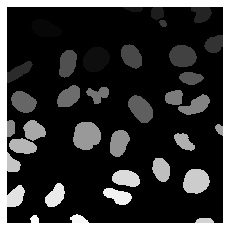

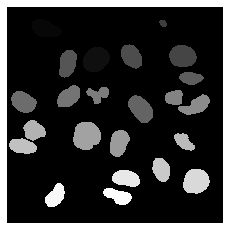

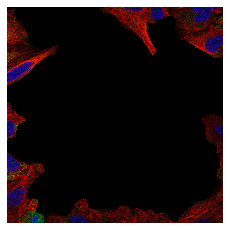

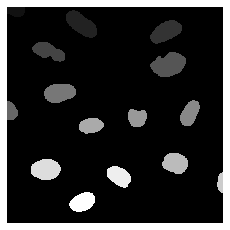

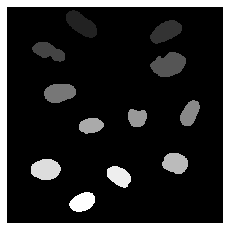

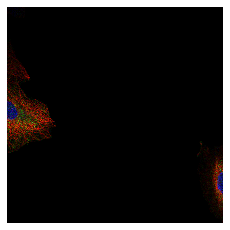

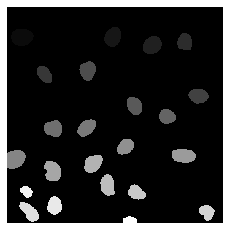

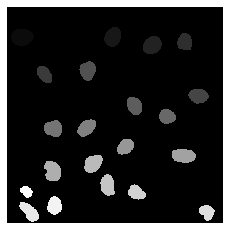

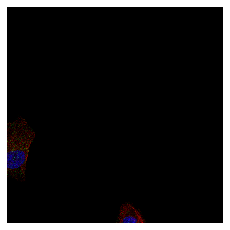

In [13]:
total_num_removed = 0
total_num_original = 0
for cell_mask_path, nuclei_mask_path, image_path in zip(cell_mask_paths, nuclei_mask_paths, dev_image_paths):
    image = np.load(image_path / "images.npy").squeeze()
    cell_mask = np.load(cell_mask_path)
    nuclei_mask = np.load(nuclei_mask_path)
    microshow(nuclei_mask)
    new_cell_mask, new_nuclei_mask, n_removed = clear_border(cell_mask, nuclei_mask)
    total_num_removed += n_removed
    n_original = len(np.unique(nuclei_mask))
    total_num_original += n_original
    microshow(new_nuclei_mask)
    microshow((new_cell_mask != cell_mask) * image, cmaps=["pure_green", "pure_red", "pure_blue"])
print("Fraction removed from border clearing:", total_num_removed / total_num_original)

Fraction removed from removing small objects: 0.0663265306122449


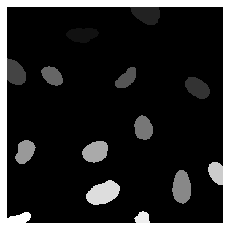

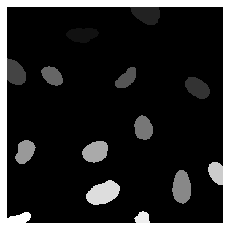

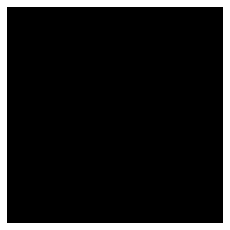

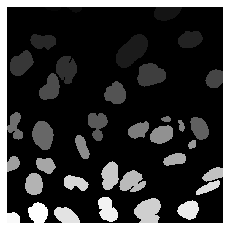

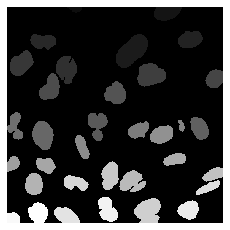

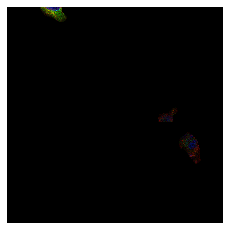

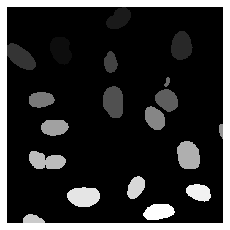

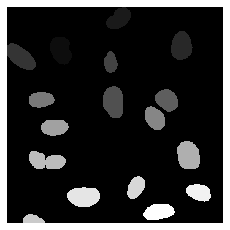

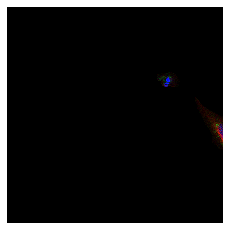

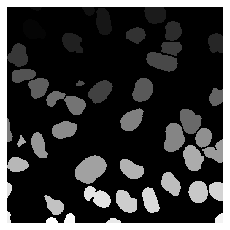

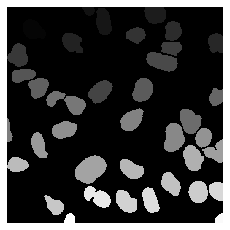

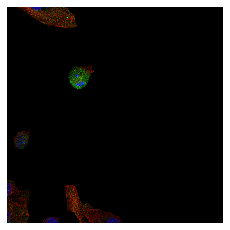

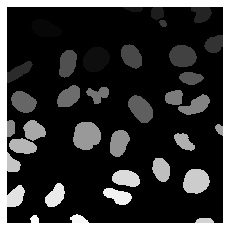

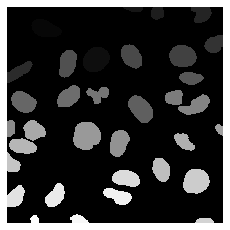

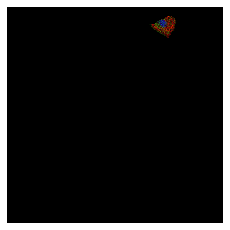

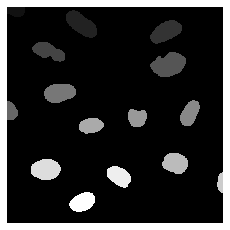

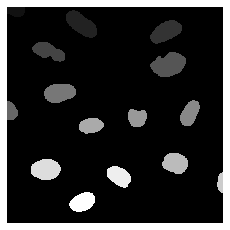

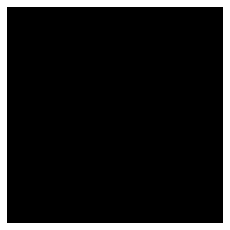

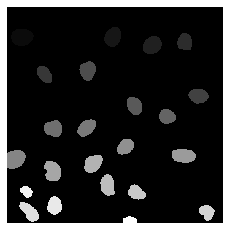

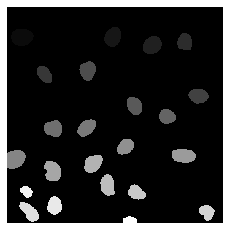

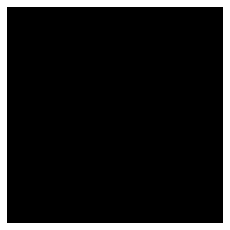

In [14]:
min_size = 5000
total_num_removed = 0
total_num_original = 0
for cell_mask_path, nuclei_mask_path, image_path in zip(cell_mask_paths, nuclei_mask_paths, dev_image_paths):
    image = np.load(image_path / "images.npy").squeeze()
    cell_mask = np.load(cell_mask_path)
    nuclei_mask = np.load(nuclei_mask_path)
    microshow(nuclei_mask)
    new_cell_mask, new_nuclei_mask, n_removed = remove_small_objects(cell_mask, nuclei_mask, min_size=min_size)
    total_num_removed += n_removed
    n_original = len(np.unique(nuclei_mask))
    total_num_original += n_original
    microshow(new_nuclei_mask)
    microshow((new_cell_mask != cell_mask) * image, cmaps=["pure_green", "pure_red", "pure_blue"])
print("Fraction removed from removing small objects:", total_num_removed / total_num_original)

In [15]:
def save_cleaned_images(
    cell_mask_paths,
    nuclei_mask_paths,
    rm_border=True, # removes cells with nuclei touching the border
    remove_size=2500, # remove cells smaller than remove_size, based on the area of the bounding box, honestly could be higher, mb 2500. Make 0 to turn off.
    # dialation_radius=0, # this is for 2048x2048 images adjust as needed. Make 0 to turn off.
):
    num_original = 0
    num_removed = 0
    for cell_mask_path, nuclei_mask_path in zip(cell_mask_paths, nuclei_mask_paths):
        cell_mask = np.load(cell_mask_path).squeeze()
        nuclei_mask = np.load(nuclei_mask_path).squeeze()
        assert set(np.unique(nuclei_mask)) == set(np.unique(cell_mask)), f"Mask mismatch before cleaning, nuclei: {np.unique(nuclei_mask)}, cell: {np.unique(cell_mask)}"
        num_original += len(np.unique(nuclei_mask))
        if rm_border:
            cell_mask, nuclei_mask, n_removed = clear_border(cell_mask, nuclei_mask)
            num_removed += n_removed
        if remove_size > 0:
            cell_mask, nuclei_mask, n_removed = remove_small_objects(cell_mask, nuclei_mask, min_size=min_size)
            num_removed += n_removed
        assert set(np.unique(nuclei_mask)) == set(np.unique(cell_mask)), f"Mask mismatch after cleaning, nuclei: {np.unique(nuclei_mask)}, cell: {np.unique(cell_mask)}"
        np.save(cell_mask_path, cell_mask)
        np.save(nuclei_mask_path, nuclei_mask)
    return num_original, num_removed

In [16]:
num_original, num_removed = save_cleaned_images(cell_mask_paths, nuclei_mask_paths)
print("Fraction removed:", num_removed / num_original)

Fraction removed: 0.28061224489795916


# Cropping

In [42]:
output_image_size = 256 # final sidelength of the image in pixels
cutoff = output_image_size * 3 # pixel square bounding box

In [43]:
def plot_bbox_sizes(cell_mask_paths):
    bboxes = []
    for cell_mask_path in cell_mask_paths:
        cell_mask = np.load(cell_mask_path).squeeze()
        region_props = measure.regionprops(cell_mask)
        bboxes.append(np.array([x.bbox for x in region_props]))
    bboxes = np.concatenate(bboxes, axis=0)
    bbox_widths = bboxes[:, 2] - bboxes[:, 0]
    bbox_heights = bboxes[:, 3] - bboxes[:, 1]
    kdeplot = sns.jointplot(x=bbox_widths, y=bbox_heights, kind="kde", color="#4CB391")
    # add lines to ax representing the cutoff boundaries above
    for ax in (kdeplot.ax_joint, kdeplot.ax_marg_x):
        ax.axvline(cutoff, color='crimson', ls='--')
    for ax in (kdeplot.ax_joint, kdeplot.ax_marg_y):
        ax.axhline(cutoff, color='crimson', ls='--')


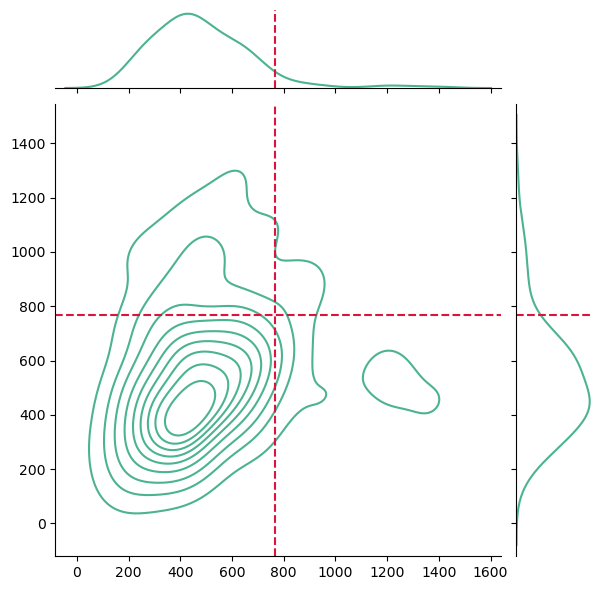

In [44]:
plot_bbox_sizes(cell_mask_paths)

Large bboxes found for /home/ishang/HPA-embedding/dev-dataset/C_1--Stage01/cell_masks.npy
bbox width: 474, bbox height: 1140
(3, 621, 768)
bbox width: 1174, bbox height: 584
(3, 768, 676)
bbox width: 830, bbox height: 856
(3, 768, 768)
bbox width: 947, bbox height: 463
(3, 768, 768)
bbox width: 1381, bbox height: 440
(3, 768, 768)
bbox width: 1243, bbox height: 501
(3, 768, 634)
bbox width: 616, bbox height: 1268
(3, 692, 768)


/home/ishang/miniconda3/envs/data-prep/lib/python3.8/site-packages/microfilm/microplot.py:164: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  microim.fig = plt.figure(frameon=False, dpi=microim.dpi)


Large bboxes found for /home/ishang/HPA-embedding/dev-dataset/B_1--Stage01/cell_masks.npy
bbox width: 886, bbox height: 866
(3, 768, 768)
bbox width: 360, bbox height: 886
(3, 768, 768)
bbox width: 379, bbox height: 1050
(3, 768, 768)
bbox width: 426, bbox height: 879
(3, 597, 768)
bbox width: 242, bbox height: 988
(3, 505, 768)


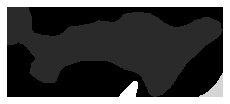

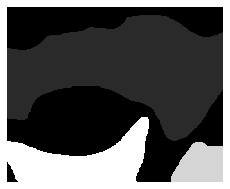

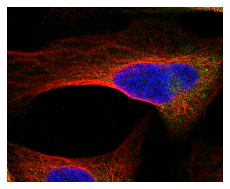

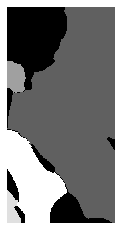

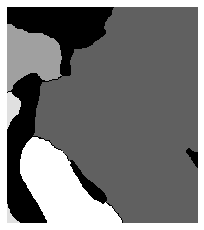

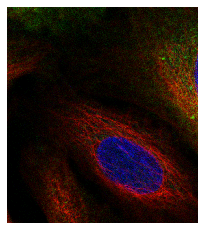

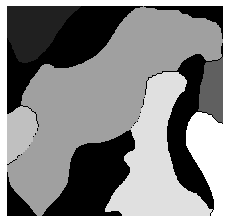

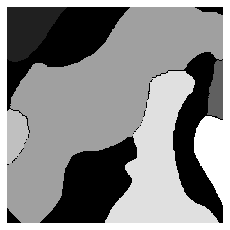

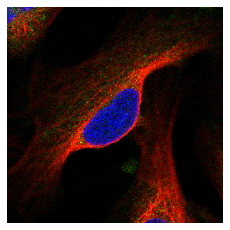

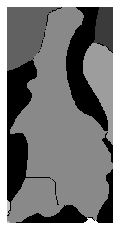

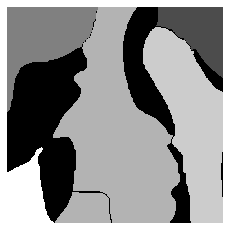

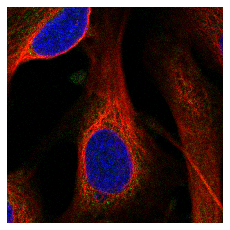

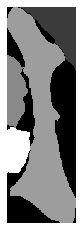

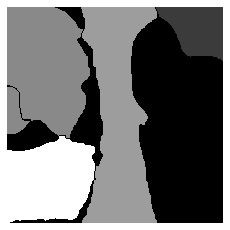

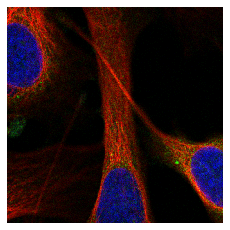

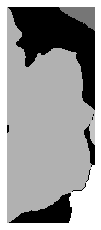

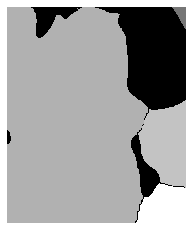

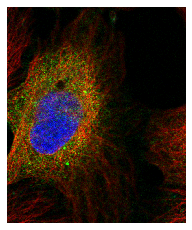

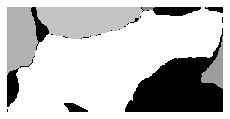

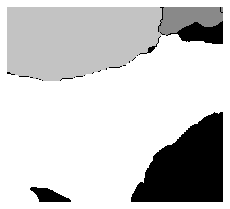

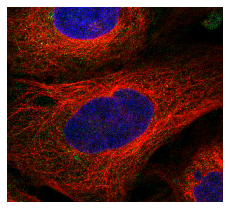

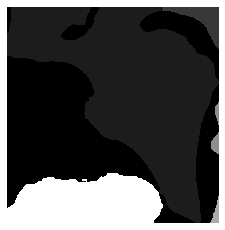

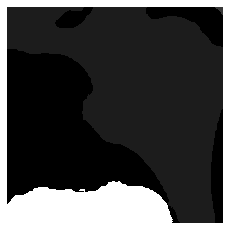

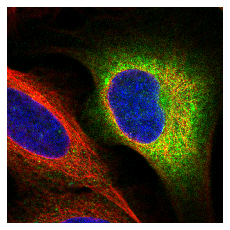

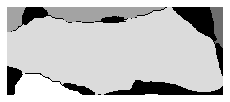

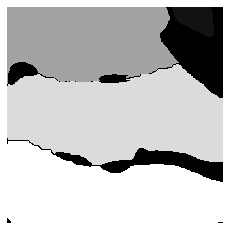

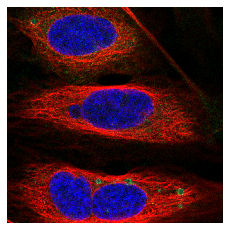

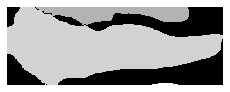

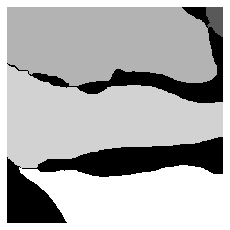

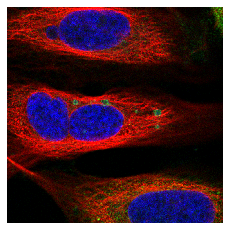

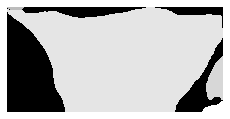

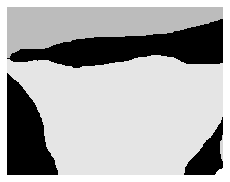

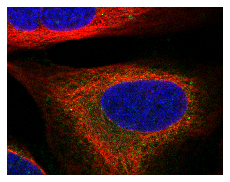

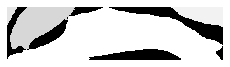

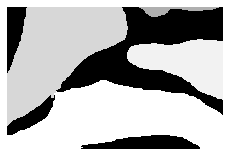

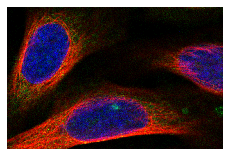

In [ ]:
# Crop images to the bbox cutoff and show examples of the ones with bboxes larger than the cutoff
def preview_crop_issues(cell_mask_paths, cutoff):
    total_shown = 0
    for cell_mask_path in cell_mask_paths:
        cell_mask = np.load(cell_mask_path).squeeze()
        region_props = measure.regionprops(cell_mask)
        bboxes = np.array([x.bbox for x in region_props])
        bbox_widths = bboxes[:, 2] - bboxes[:, 0]
        bbox_heights = bboxes[:, 3] - bboxes[:, 1]
        large_bboxes = np.logical_or(bbox_widths > cutoff, bbox_heights > cutoff)
        if np.sum(large_bboxes) > 0:
            print(f"Large bboxes found for {cell_mask_path}")
            for i in np.where(large_bboxes)[0]:
                print(f"bbox width: {bbox_widths[i]}, bbox height: {bbox_heights[i]}")
                microshow(cell_mask[bboxes[i][0]:bboxes[i][2], bboxes[i][1]:bboxes[i][3]])
                center = np.array([np.mean([bboxes[i][0], bboxes[i][2]]), np.mean([bboxes[i][1], bboxes[i][3]])])
                microshow(cell_mask[max(0, int(center[0] - cutoff / 2)):min(cell_mask.shape[0], int(center[0] + cutoff / 2)), max(0, int(center[1] - cutoff / 2)):min(cell_mask.shape[1], int(center[1] + cutoff / 2))])
                image = np.load(str(cell_mask_path).replace("cell_masks.npy", "images.npy")).squeeze()
                cropped = image[:, max(0, int(center[0] - cutoff / 2)):min(cell_mask.shape[0], int(center[0] + cutoff / 2)), 
                                       max(0, int(center[1] - cutoff / 2)):min(cell_mask.shape[1], int(center[1] + cutoff / 2))]
                masked_cropped = cropped * (cell_mask[cell_mask == i] > 0)
                print(masked_cropped.shape)
                microshow(masked_cropped, cmaps=["pure_green", "pure_red", "pure_blue"])
                total_shown += 1
            if total_shown > 10:
                return
preview_crop_issues(cell_mask_paths, cutoff)

## Intensity Normalization